# TPC-DS 10GiB - Apache Spark acceleration on GPU with RAPIDS Spark

based on https://colab.research.google.com/github/LucaCanali/Miscellaneous/blob/master/Performance_Testing/TPCDS_PySpark/Labs_and_Notes/TPCDS_PySpark_getstarted.ipynb#scrollTo=6bab7772

# Install packages

In [1]:
spark_version='3.5.0'
rapids_version='24.10.0'

In [3]:
%pip install --quiet \
  tpcds_pyspark \
  pyspark=={spark_version} \
  sparkmeasure \
  pandas \
  matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import modules

In [4]:
from importlib.resources import files
from pyspark.sql import SparkSession
from tpcds_pyspark import TPCDS
import glob
import os
import pandas as pd
import re
import time

# Download TPC-DS 10GiB Scale Parquet Dataset

In [5]:
if not os.path.isdir('tpcds_10'):
  if not os.path.isfile('tpcds_10.zip'):
    !wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
  !unzip -q tpcds_10.zip

# Init a SparkSession with RAPIDS Spark

## Detect Scala Version used in PySpark package

In [6]:
pyspark_files = files('pyspark')
spark_sql_jar_path, *_ = glob.glob(f"{pyspark_files}/*/spark-sql_*jar")
spark_sql_jar = os.path.basename(spark_sql_jar_path)
scala_version = re.search(r'^spark-sql_(\d+.\d+)-.*\.jar$', spark_sql_jar).group(1)

## Find spark-measure artifact

In [7]:
tpcds_pyspark_files = files('tpcds_pyspark')
spark_measure_jar_paths = glob.glob(f"{tpcds_pyspark_files}/spark-measure_{scala_version}-*.jar")
assert spark_measure_jar_paths, f"No spark-measure artifact built for Pyspark's Scala version {scala_version}"
spark_measure_jar_paths.sort(reverse=True)
spark_measure_jar_path, *_ = spark_measure_jar_paths

In [8]:
spark = (
    SparkSession.builder
      .appName('TPCDS PySpark RAPIDS=ON/OFF')
      .config('spark.driver.memory', '5g')
      .config('spark.plugins', 'com.nvidia.spark.SQLPlugin')
      .config('spark.jars', spark_measure_jar_path)
      .config('spark.jars.packages', f"com.nvidia:rapids-4-spark_{scala_version}:{rapids_version}")
      .getOrCreate()
)


24/10/23 14:46:45 WARN Utils: Your hostname, e780a48-lcedt resolves to a loopback address: 127.0.1.1; using 10.112.215.249 instead (on interface enp36s0f0)
24/10/23 14:46:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/gshegalov/.ivy2/cache
The jars for the packages stored in: /home/gshegalov/.ivy2/jars
com.nvidia#rapids-4-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-93f929a5-5993-4f3d-9421-bd096589e319;1.0
	confs: [default]
	found com.nvidia#rapids-4-spark_2.12;24.10.0 in central
:: resolution report :: resolve 69ms :: artifacts dl 3ms
	:: modules in use:
	com.nvidia#rapids-4-spark_2.12;24.10.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-93f929a5-5993-4f3d-9421-

# Verify SQL Acceleration on GPU can be enabled by checking the query plan

In [9]:
spark.conf.set('spark.rapids.sql.enabled', True)
sum_df = spark.range(1000).selectExpr('SUM(*)')
sum_df.collect()
sum_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=22]
   +- GpuHashAggregate (keys=[], functions=[gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=21]
      +- GpuShuffleCoalesce 1073741824, [loreId=20]
         +- ShuffleQueryStage 0
            +- GpuColumnarExchange gpusinglepartitioning$(), ENSURE_REQUIREMENTS, [plan_id=64], [loreId=17]
               +- GpuHashAggregate (keys=[], functions=[partial_gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=16]
                  +- GpuRange (0, 1000, step=1, splits=64)
+- == Initial Plan ==
   HashAggregate(keys=[], functions=[sum(id#0L)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=11]
      +- HashAggregate(keys=[], functions=[partial_sum(id#0L)])
         +- Range (0, 1000, step=1, splits=64)




# TPCDS App

In [10]:
# https://github.com/LucaCanali/Miscellaneous/tree/master/Performance_Testing/TPCDS_PySpark/tpcds_pyspark/Queries

# queries = None to run all (takes much longer)
queries = None
queries = [
    'q14a',
    'q14b',
    'q23a',
    'q23b',
    # 'q24a',
    # 'q24b',
    # 'q88',
]

demo_start = time.time()
tpcds = TPCDS(data_path='./tpcds_10', num_runs=1, queries_repeat_times=1, queries=queries)

sparkMeasure jar path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/spark-measure_2.12-0.24.jar
TPCDS queries path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/Queries


24/10/23 14:47:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Register TPC-DS tables before running queries

In [11]:
tpcds.map_tables()

Creating temporary view catalog_returns


24/10/23 14:47:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Creating temporary view catalog_sales
Creating temporary view inventory
Creating temporary view store_returns
Creating temporary view store_sales
Creating temporary view web_returns
Creating temporary view web_sales
Creating temporary view call_center
Creating temporary view catalog_page
Creating temporary view customer
Creating temporary view customer_address
Creating temporary view customer_demographics
Creating temporary view date_dim
Creating temporary view household_demographics
Creating temporary view income_band
Creating temporary view item
Creating temporary view promotion
Creating temporary view reason
Creating temporary view ship_mode
Creating temporary view store
Creating temporary view time_dim
Creating temporary view warehouse
Creating temporary view web_page
Creating temporary view web_site


## Measure Apache Spark CPU

In [12]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', False)
%time tpcds.run_TPCDS()
cpu_grouped_results = tpcds.grouped_results_pdf.copy()
cpu_grouped_results


Run 0 - query q14a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-23 14:47:40
...Elapsed Time = 9.31 sec
...Executors Run Time = 149.86 sec
...Executors CPU Time = 85.31 sec
...Executors JVM GC Time = 30.7 sec
...Average Active Tasks = 16.1

Run 0 - query q14b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-23 14:47:53
...Elapsed Time = 5.27 sec
...Executors Run Time = 91.68 sec
...Executors CPU Time = 55.95 sec
...Executors JVM GC Time = 24.74 sec
...Average Active Tasks = 17.4

Run 0 - query q23a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-23 14:48:00
...Elapsed Time = 8.73 sec
...Executors Run Time = 199.52 sec
...Executors CPU Time = 138.3 sec
...Executors JVM GC Time = 42.51 sec
...Average Active Tasks = 22.9

Run 0 - query q23b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-23 14:48:10
...Elapsed Time = 8.83 sec
...Executors Run Time = 224.27 sec
...Executors CPU Time = 145.62 sec
...Executors JVM GC Time = 57.8 sec
...Average Active Tasks = 25.4
CPU times: user 85.1 ms, sys: 25.7 ms, total: 111 ms
Wall time: 40.3 s


,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,838,9308,18042,149861,85308,7838,2915,271,...,551,0,878437913,878437913,0,0,875325021,62516924,16,9
1,q14b,24,636,5272,8360,91678,55951,2927,1578,218,...,513,0,1013592969,1013592969,0,0,529675847,40865273,17,5
2,q23a,18,621,8730,15069,199518,138301,2173,1338,107,...,2269,0,1115089630,1115089630,0,0,1085198863,41990073,22,8
3,q23b,21,690,8831,17842,224270,145622,3162,1751,120,...,4779,0,1200330085,1200330085,0,0,1097570340,42452502,25,8


## Measure Apache Spark GPU

In [13]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', True)
%time tpcds.run_TPCDS()
gpu_grouped_results = tpcds.grouped_results_pdf.copy()
gpu_grouped_results


Run 0 - query q14a - attempt 0 - starting...


24/10/23 14:48:22 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec

24/10/23 14:48:23 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/23 14:48:23 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/23 14:48:23 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/23 14:48:23 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/23 14:48:23 WARN MultiFileReaderThreadPool: Configuring the file read

Job finished
...Start Time = 2024-10-23 14:48:20
...Elapsed Time = 6.05 sec
...Executors Run Time = 123.47 sec
...Executors CPU Time = 17.23 sec
...Executors JVM GC Time = 7.43 sec
...Average Active Tasks = 20.4

Run 0 - query q14b - attempt 0 - starting...


24/10/23 14:48:30 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-23 14:48:30
...Elapsed Time = 2.85 sec
...Executors Run Time = 86.64 sec
...Executors CPU Time = 12.98 sec
...Executors JVM GC Time = 7.06 sec
...Average Active Tasks = 30.4

Run 0 - query q23a - attempt 0 - starting...


24/10/23 14:48:34 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-23 14:48:34
...Elapsed Time = 3.22 sec
...Executors Run Time = 98.1 sec
...Executors CPU Time = 22.08 sec
...Executors JVM GC Time = 4.58 sec
...Average Active Tasks = 30.5

Run 0 - query q23b - attempt 0 - starting...


24/10/23 14:48:39 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-23 14:48:38
...Elapsed Time = 4.79 sec
...Executors Run Time = 183.46 sec
...Executors CPU Time = 23.68 sec
...Executors JVM GC Time = 6.21 sec
...Average Active Tasks = 38.3
CPU times: user 45.8 ms, sys: 22.7 ms, total: 68.5 ms
Wall time: 24.3 s


,query,numStages,numTasks,elapsedTime,stageDuration,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,...,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleTotalBytesRead,shuffleLocalBytesRead,shuffleRemoteBytesRead,shuffleRemoteBytesReadToDisk,shuffleBytesWritten,shuffleRecordsWritten,avg_active_tasks,elapsed_time_seconds
0,q14a,30,862,6048,10688,123472,17226,7391,3881,36,...,718,0,696421878,696421878,0,0,693865654,18794,20,6
1,q14b,24,661,2848,4761,86635,12985,3519,2711,86,...,695,0,767451618,767451618,0,0,421600742,15346,30,2
2,q23a,18,589,3221,5354,98104,22078,2304,2092,79,...,1727,0,897013287,897013287,0,0,878908228,15223,30,3
3,q23b,21,651,4794,8100,183457,23683,4522,2527,35,...,3774,0,952869300,952869300,0,0,888393294,16352,38,4


## Show Speedup Factors achieved by GPU


In [14]:
res = pd.merge(cpu_grouped_results, gpu_grouped_results, on='query', how='inner', suffixes=['_cpu', '_gpu'])
res['speedup'] = res['elapsedTime_cpu'] / res['elapsedTime_gpu']
res = res.sort_values(by='elapsedTime_cpu', ascending=False)

In [15]:
demo_dur = time.time() - demo_start
print(f"CPU and GPU run took: {demo_dur=} seconds")

CPU and GPU run took: demo_dur=112.37040138244629 seconds


<Axes: title={'center': 'TPC-DS query elapsedTime on CPU vs GPU (lower is better)'}, xlabel='query'>

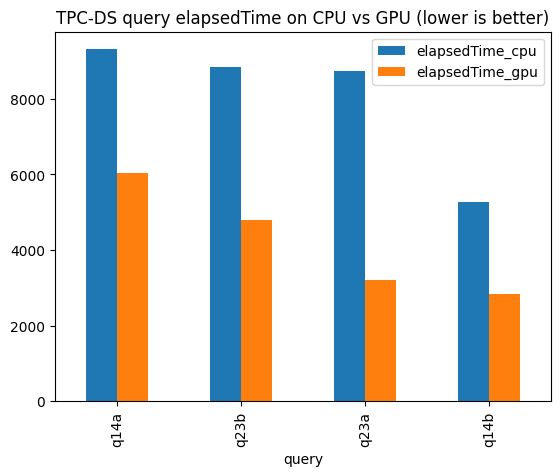

In [16]:
res.plot(title='TPC-DS query elapsedTime on CPU vs GPU (lower is better)', kind='bar', x='query', y=['elapsedTime_cpu', 'elapsedTime_gpu'])

<Axes: title={'center': 'Speedup factors of TPC-DS queries on GPU'}, xlabel='query'>

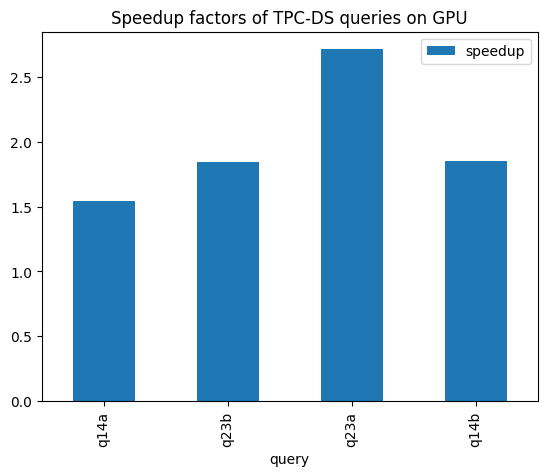

In [17]:
res.plot(title='Speedup factors of TPC-DS queries on GPU', kind='bar', x='query', y='speedup' )

# Run Queries interactively

In [23]:
query = 'q88'
with open(f"{tpcds_pyspark_files}/Queries/{query}.sql") as f:
  q = f.read()

In [24]:
print(q)

SELECT *
FROM
  (SELECT count(*) h8_30_to_9
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 8
    AND time_dim.t_minute >= 30
    AND (
    (household_demographics.hd_dep_count = 4 AND household_demographics.hd_vehicle_count <= 4 + 2)
      OR
      (household_demographics.hd_dep_count = 2 AND household_demographics.hd_vehicle_count <= 2 + 2)
      OR
      (household_demographics.hd_dep_count = 0 AND
        household_demographics.hd_vehicle_count <= 0 + 2))
    AND store.s_store_name = 'ese') s1,
  (SELECT count(*) h9_to_9_30
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 9
    AND time_dim.t_minute < 30
    AND (
    (household_demographics.hd_

In [25]:
spark.conf.set('spark.rapids.sql.enabled', True)
df  = spark.sql(q)
%time df.collect()

CPU times: user 2.45 ms, sys: 1.97 ms, total: 4.43 ms
Wall time: 1.66 s


[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]